<h1>Example Description</h1>
<p>We have an object moving in the plane and our state(x) is it's position, velocity, and acceleration in the x and y directions. We have 4 nodes in a square/loop which each get measurements of the location every second with different noise. They communicate with their neighbors and weigh estimates equally (33/100 from their two neighbor estimates and 34/100 for personal estimate).</p>
<p>The plots show the Estimates vs. Measurements of each of the four nodes and then a convergence plot that averages the error from each of the four nodes.</p>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

%run ./DiffKF.ipynb

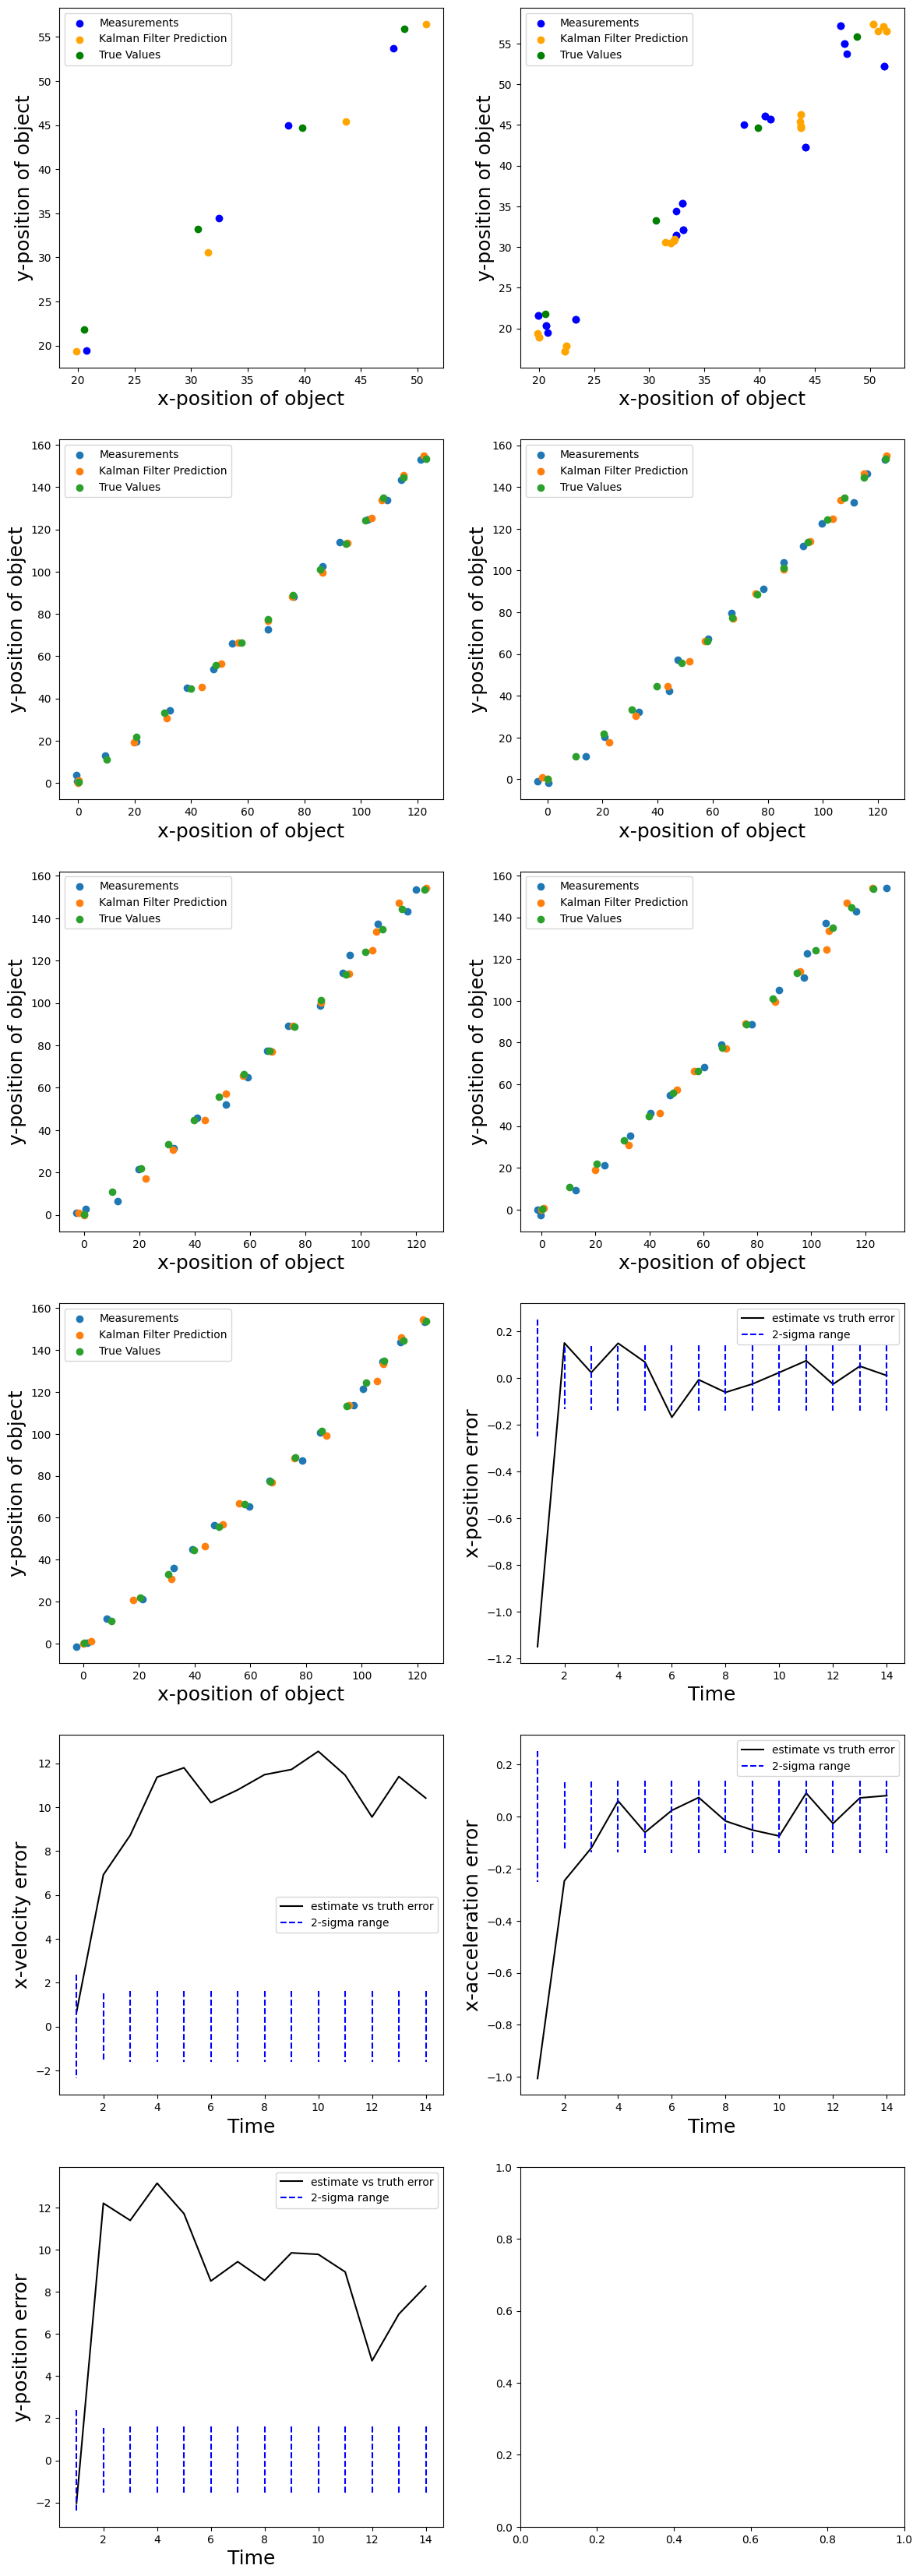

In [ ]:
np.random.seed(163)
def example(iters):

    dt = 10 # time step
    q = 0.001 # process noise

    C = np.array([[0.34,0.33, 0, 0, 0.33],[0.33,0.34,0.33,0,0],[0,0.33,0.34,0.33,0],[0,0,0.33,0.34,0.33],[0.33,0,0,0.33,0.34]]) # weighted adjacency matrix
    n = len(C[0]) # number of nodes

    A = np.array([[1, dt, 0, 0], [0, 1, 0, 0],[0,0,1,dt], [0, 0, 0, 1]]) # state transition matrix
    H = np.array([[1, 0, 0, 0],[0,0,1,0]]) # observation matrix

    B = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]) # control input matrix
    u = np.array([[0,0,0,0]]).T # initial control input

    Q = q*np.array([[(dt**3)/3, (dt**2)/2, 0, 0], [(dt**2)/2, dt, 0, 0],[0,0,(dt**3)/3,(dt**2)/2], [0, 0, (dt**2)/2, dt]]) # process noise covariance matrix
    R = np.array([[4,0],[0,4]]) # measurement noise covariance matrix

    F = [A for _ in range(n)]
    G = [np.eye(4) for _ in range(n)]
    H = [np.array([[1, 0, 0, 0],[0,0,1,0]]) for _ in range(n)]

    Q = [Q for _ in range(n)]
    R = [R for _ in range(n)]

    # This is the true starting value that we update to get true values
    xp = np.array([[0,1,0,1]]).T

    m = len(xp)

    #These are random first estimates for each of the nodes
    # x0 = [np.array([[np.random.normal(0,2) for _ in range(6)]]).T for k in range(n)]
    x0 = [np.copy(xp) for _ in range(n)]
    P = [5*np.eye(4) for _ in range(n)]

    DKF = DiffKF(C,F,G,H,R,Q,x0,P)

    procc_noise = lambda i : np.linalg.cholesky(Q[i]) @ np.random.normal(np.array([[0,0,0,0]]).T)
    measure_noise = lambda i : np.linalg.cholesky(R[i]) @ np.random.normal(np.array([[0,0]]).T)

    # Initial measurement vector z for each node, including measurement noise
    z = [(H[0] @ xp)+measure_noise(i) for i in range(n)]

    # arrays to store the true states, predictions, measurements, errors, and covariances over time
    truth = np.zeros((iters+1,m,1))
    truth[0] = xp+procc_noise(0)
    predictions = {i:[] for i in range(n)}
    measurements = [z]
    errors = np.zeros((iters,n,m,1))
    P_hist = np.zeros((iters,n,m,m))

    for i in range(iters):
        x = DKF.predict()
        z = [(H[0] @ truth[i])+measure_noise(j) for j in range(n)]
        truth[i+1] = F[0]@truth[i]+procc_noise(0)
        measurements.append(z)
        errors[i] = np.array([node.x-truth[i-1] for node in DKF.nodes])
        P_hist[i] = np.array([node.P for node in DKF.nodes])
        DKF.update(z)
        for j in range(n):
            predictions[j].append(H[j]@DKF.nodes[j].x)


    fig,axs = plt.subplots((n+m)//2 +2,2, figsize=(14, 7*((n+m)//2+2)))
    example_i = 2
    for k in range(2):
        axs[0][k].scatter([x[0][0][0] for x in measurements[example_i+1:example_i+5]],[x[0][1][0] for x in measurements[example_i+1:example_i+5]], label = 'Measurements', color = "blue")
        for i in range(1,n-1):
            axs[0][1].scatter([x[i][0][0] for x in measurements[example_i+1:example_i+5]],[x[i][1][0] for x in measurements[example_i+1:example_i+5]], color = "blue")
            axs[0][1].scatter([x[0][0] for x in predictions[i][example_i:example_i+4]],[x[1][0] for x in predictions[i][example_i:example_i+4]], color = "orange")
        axs[0][k].scatter([x[0][0] for x in predictions[0][example_i:example_i+4]],[x[1][0] for x in predictions[0][example_i:example_i+4]], label = 'Kalman Filter Prediction', color = "orange")
        axs[0][k].scatter([(H[0]@x)[0][0] for x in truth[example_i:example_i+4]],[(H[0]@x)[1][0] for x in truth[example_i:example_i+4]], label = 'True Values', color = "green")
        axs[0][k].set_xlabel("x-position of object", fontsize = 18)
        axs[0][k].set_ylabel("y-position of object", fontsize = 18)
        axs[0][k].legend()

    for i in range(n):
        axs[i//2+1][i%2].scatter([x[i][0][0] for x in measurements],[x[i][1][0] for x in measurements], label = 'Measurements')
        axs[i//2+1][i%2].scatter([x[0][0] for x in predictions[i]],[x[1][0] for x in predictions[i]], label = 'Kalman Filter Prediction')
        axs[i//2+1][i%2].scatter([(H[i]@x)[0][0] for x in truth[:-1]],[(H[i]@x)[1][0] for x in truth[:-1]], label = 'True Values')
        axs[i//2+1][i%2].set_xlabel("x-position of object", fontsize = 18)
        axs[i//2+1][i%2].set_ylabel("y-position of object", fontsize = 18)
        axs[i//2+1][i%2].legend()

    t_hist = np.arange(0, iters, 1)
    labels = ["x-position", "x-velocity","x-acceleration","y-position","y-velocity","y-acceleration"]
    for k in range(n,n+m):
        axs[k//2+1][k%2].plot(t_hist[1:], errors[1:, 1, k%m], 'k',label = "estimate vs truth error")
        axs[k//2+1][k%2].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([np.sqrt(P_hist[1, 1,k%m, k%m]), -np.sqrt(P_hist[1, 1,k%m, k%m])]), 'b--',label = "2-sigma range")
        axs[k//2+1][k%2].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([np.sqrt(P_hist[2:, 1,k%m, k%m]), -np.sqrt(P_hist[2:, 1,k%m, k%m])]), 'b--')
        axs[k//2+1][k%2].set_xlabel("Time", fontsize = 18)
        axs[k//2+1][k%2].set_ylabel(labels[(k-n)%m]+" error", fontsize = 18)
        axs[k//2+1][k%2].legend()

    plt.show()

example(15)